## In this notebook I will be implementing a dense neural network 

I will building a simple binary image classification model with a two layer dense neural network with 10 units in each of the hidden layers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import latex
import sklearn

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using mnist handwritten digits as data (28 x 28 pixel images)
# Note - I will untimately be only using two classes within this dataset
from mnist import MNIST
mndata = MNIST('../data/dense')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train = np.array(images_train)
y_train = np.array(labels_train)
X_test = np.array(images_test)
y_test = np.array(labels_test)

y_train.shape = (60000,1)
y_test.shape = (10000,1)

In [4]:
# Number of unique digits for the overall data set
no_uniq = np.unique(y_train)
no_uniq

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

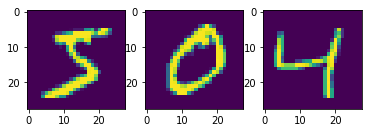

In [5]:
# Examples of 28x28 images
example_image1 = np.reshape(np.array(images_train[0]), (28,28))
example_image2 = np.reshape(np.array(images_train[1]), (28,28))
example_image3 = np.reshape(np.array(images_train[2]), (28,28))
f, axarr = plt.subplots(1,3)
axarr[0].imshow(example_image1)
axarr[1].imshow(example_image2)
axarr[2].imshow(example_image3)
plt.show()

In [6]:
print("Number of training images:", len(images_train))
print("Number of testing images:", len(images_test))
print("The shape of each number: {} x 1".format(len(images_train[0])))

Number of training images: 60000
Number of testing images: 10000
The shape of each number: 784 x 1


#### Note - As mentioned earlier, I will initially only be keeping two classes

In [7]:
# Creating a mask to extract my two classes for training data
bool1 = (y_train == 0)
bool2 = (y_train == 1)
mask = bool1 | bool2
assert sum(mask) == (sum(bool1) + sum(bool2))

In [8]:
# Creating a mask to extract my two classes for testing data
bool3 = (y_test == 0)
bool4 = (y_test == 1)
mask2 = bool3 | bool4
assert sum(mask2) == (sum(bool3) + sum(bool4))

In [9]:
# Updating training parameters
y_train_small = y_train[mask]
y_train_small.shape = (int(sum(mask)),1)
x_mask = np.repeat(mask, X_train.shape[1], axis = 1)
X_train_small = np.extract(x_mask, X_train)
X_train_small.shape = (int(sum(mask)),784)

In [10]:
# Updating testing parameters
y_test_small = y_test[mask2]
y_test_small.shape = (int(sum(mask2)),mask2.shape[1])
x_mask2 = np.repeat(mask2, X_test.shape[1], axis = 1)
X_test_small = np.extract(x_mask2, X_test)
X_test_small.shape = (int(sum(mask2)), 784)

In [11]:
# Relu activation function
def relu(z):
    return np.maximum(0,z)

In [12]:
# Returns the sigmoid activation of input 
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

Forward propagation and prediction:

$$ z^{[1](i)} = W^{[1]}x^{(i)}+b^{[1]} $$
$$ a^{[1](i)} = relu(z^{[1](i)}) $$

$$ z^{[2](i)} = W^{[2]}a^{[1](i)}+b^{[2]} $$
$$ a^{[2](i)} = relu(z^{[2](i)}) $$

$$ z^{[3](i)} = W^{[3]}a^{[3](i)}+b^{[3]} $$
$$ \hat{y} = a^{[3](i)} = sigmoid(z^{[3](i)}) $$

Given this is a classification problem, I am using log loss:

$$ Cost = -\frac{1}{m}\sum^{m}_{i=0}\bigg(y^{(i)}log(a^{[2](i)}) + (1-y^{(i)})log(1-a^{[2](i)})\bigg) $$

In [13]:
h_size = [10,10] # Hidden layer size (2 for this simple NN)
x_shape = len(images_train[0])
y_shape = 1 # Number of unique values for our binary classification

In [14]:
# Model cost function, cross entropy
def loss(y,y_hat):
    """
    y: actual values
    y_hat: predicted values
    """
    avg = -np.average(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))
    return np.squeeze(avg)

In [15]:
# Testing my cost function
from sklearn.metrics import log_loss
test_yhat = np.array([0.5 for i in range(12665)])
test_yhat.shape = (12665,1)
assert loss(y_train_small,test_yhat) == log_loss(y_train_small,test_yhat)

#### Xavier inspired initialization
$$ Var(W_i) = \frac{2}{n_{in}+n_{out}} $$

$$ Mean(W_i) = 0 $$

Further, n<sub>in</sub> is the number of neurons feeding into these weights

In [16]:
# Xavier inspired initialization, returns dic of weights and bias matrices
def initialize_params(h_size, x_shape, y_shape):
    """
    h_size: hidden layer shapes, list w/ 2 weights 
    x_shape: input shape, y_shape: output shape
    W1 = x_shape x h_size[0]
    b1 = h_size[0] x 1
    W2 = h_size[0] x h_size[1]
    b2 = h_size[1] x 1
    W3 = h_size[1] x y_shape
    b3 = y_shape x 1
    m x n: #output x #input 
    """
    params = {}
    params['W1'] = get_weights(h_size[0],x_shape)
    params['b1'] = np.zeros((h_size[0],1))
    params['W2'] = get_weights(h_size[1],h_size[0])
    params['b2'] = np.zeros((h_size[1],1))
    params['W3'] = get_weights(y_shape,h_size[1])
    params['b3'] = np.zeros((y_shape,1))
    return params

In [17]:
# Takes in matrix shape and returns initialized weights
def get_weights(m, n):
    """
    m: #rows 
    n: #cols
    """
    stdev = np.sqrt(2 / (m + n))
    return np.random.normal(0, stdev, size=(m,n))

In [18]:
# Getting initialized parameters for my model
params = initialize_params(h_size, x_shape, y_shape)

In [19]:
# Checking my parameter initializations
print("W1:",params['W1'].shape)
print("b1:",params['b1'].shape)
print("W2:",params['W2'].shape)
print("b2:",params['b2'].shape)
print("W3:",params['W3'].shape)
print("b3:",params['b3'].shape)

W1: (10, 784)
b1: (10, 1)
W2: (10, 10)
b2: (10, 1)
W3: (1, 10)
b3: (1, 1)


In [20]:
# Reshaping input vectors
simple_train_x = X_train_small.T
simple_test_x = X_test_small.T
simple_train_y = y_train_small.T
simple_test_y = y_test_small.T
assert simple_test_y.shape == (1, 2115)
assert simple_train_y.shape == (1, 12665)
assert simple_train_x.shape == (784,12665)
assert simple_test_x.shape == (784, 2115)

In [21]:
# Handles a single forward propagation pass
def forward_prop(X, p):
    """
    params (p): dictionary of parameters (W,b)
    X: input data of size (784,m)
    cache: holds each layer activations (a) and linear transformation (z)
    """
    Z1 = np.dot(p['W1'],X) + p['b1']
    A1 = sigmoid(Z1) #relu(Z1)  
    Z2 = np.dot(p['W2'],A1) + p['b2']
    A2 = sigmoid(Z2) #relu(Z2)  
    Z3 = np.dot(p['W3'],A2) + p['b3']
    A3 = sigmoid(Z3)
    
    cache = {"Z1": Z1,"A1": A1,"Z2": Z2,"A2": A2,"Z3": Z3, "A3": A3}
    return A3, cache

#### Backward Propagation Notable Equations

$$ dZ^{[L]} = A^{[L]} - Y $$

$$ dZ^{[l]} = da^{[l]} * g'(z^{[l]}) $$

$$ dW^{[l]} = \frac{\partial \mathcal{L} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$

$$ db^{[l]} = \frac{\partial \mathcal{L} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)} $$

$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$

In [22]:
# The derivative of relu function is 1 if z > 0, and 0 if z <= 0
def relu_deriv1(z):
    z[z > 0] = 1
    z[z <= 0] = 0
    return z

In [23]:
def relu_deriv(z):
    return 1. * (z > 0)

In [24]:
# Handles a single backward pass through the neural network
def backward_prop(X, y, c, p):
    """
    adam: boolean 
    cache (c): includes activations (A) and linear transformations (Z)
    params (p): includes weights (W) and biases (b)
    """
    m = X.shape[1] # Number of training ex
    dZ3 = c['A3'] - y
    dW3 = 1/m * np.dot(dZ3,c['A2'].T)
    db3 = 1/m * np.sum(dZ3, keepdims=True, axis=1)
    
    dA2 = np.dot(p['W3'].T, dZ3)
    dZ2 = np.multiply(dA2,(1-np.power(c['A2'], 2))) #relu_deriv(c['A2'])
    dW2 = 1/m * np.dot(dZ2,c['A1'].T)
    db2 = 1/m * np.sum(dZ2, keepdims=True, axis=1)
    
    dA1 = np.dot(p['W2'].T,dZ2)
    dZ1 = np.multiply(dA1,(1-np.power(c['A1'], 2))) # relu_deriv(c['A1'])  
    dW1 = 1/m * np.dot(dZ1,X.T)
    db1 = 1/m * np.sum(dZ1, keepdims=True, axis=1)
    
    grads = {"dW1":dW1,"db1":db1,"dW2":dW2,"db2":db2,"dW3":dW3,"db3":db3}
    return grads

In [25]:
# Updates the parameters based on the grads and learning rate
def update_params(p, g,lr):
    """
    params (p): holds old parameters
    grads (g): holds old grads
    """
    W1 = p['W1'] - lr*g['dW1']
    b1 = p['b1'] - lr*g['db1']
    W2 = p['W2'] - lr*g['dW2']
    b2 = p['b2'] - lr*g['db2']
    W3 = p['W3'] - lr*g['dW3']
    b3 = p['b3'] - lr*g['db3']
    
    params = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    return params

In [26]:
# Does a number of steps, calculates cost, learns using gradient descent
def nn_model(X,y,n_h=[10,10],num_iter=1000,lr=0.01, print_cost=True, adam=False,B1=0.9,B2=0.999,e=10e-8):
    """
    X: dataset of shape (784,m)
    y: labels of shape (1,m)
    n_h: list of hidden layer sizes [10,10]
    num_iter: number of epochs
    print_cost: determines if you want to print cost every 100 training cycles
    returns list of costs per epoch and final params
    """
    params = initialize_params(n_h, X.shape[0], y.shape[0]) #initial parameters
    costs = [] # Stores cost after each iteration
    ap = {"Vdw1":0,"Vdb1":0,"Sdw1":0,"Sdb1":0,
          "Vdw2":0,"Vdb2":0,"Sdw2":0,"Sdb2":0,
          "Vdw3":0,"Vdb3":0,"Sdw3":0,"Sdb3":0} # Adam parameters
    
    for i in range(num_iter):
        A3,cache = forward_prop(X,params) 
        acost = loss(y,A3)
        costs.append(acost)
        if i % 100 == 0 and print_cost:
            print("Cost at epoch {}: {}".format(i,acost))
        grads = backward_prop(X, y, cache, params)
        if adam: # If we are using adam optimization
            params,ap = update_params_adam(params, grads, lr, ap, B1, B2, e, i)
        else:
            params = update_params(params,grads,lr)
        
    return costs,params 

In [27]:
# Creates a vector of predictions based on input 
def predict(X, params):
    """
    Uses learnt parameters 
    This returns a vector of predictions (as probabilities)
    """
    A3, cache = forward_prop(X,params)
    return A3

In [28]:
# Testing out my neural network model - using simple_train_x,simple_test_x,simple_train_y,simple_test_y
costs,params = nn_model(simple_train_x,simple_train_y,[10,10],3000,0.03, True)

Cost at epoch 0: 0.7252124447425526
Cost at epoch 100: 0.568145294135091
Cost at epoch 200: 0.45854988430989907
Cost at epoch 300: 0.35071410668415204
Cost at epoch 400: 0.2676864999700779
Cost at epoch 500: 0.21103913213499992
Cost at epoch 600: 0.17187153811848774
Cost at epoch 700: 0.1452931168173337
Cost at epoch 800: 0.12571895091692942
Cost at epoch 900: 0.11181452852594194
Cost at epoch 1000: 0.1010710109213214
Cost at epoch 1100: 0.09227733612352099
Cost at epoch 1200: 0.08530412187461567
Cost at epoch 1300: 0.07916853860593473
Cost at epoch 1400: 0.07381468214598437
Cost at epoch 1500: 0.06982446921024245
Cost at epoch 1600: 0.06610348030205106
Cost at epoch 1700: 0.06239461957250472
Cost at epoch 1800: 0.06008961088145207
Cost at epoch 1900: 0.05794235206471129
Cost at epoch 2000: 0.05573965664956794
Cost at epoch 2100: 0.053540390586709154
Cost at epoch 2200: 0.05188380700459439
Cost at epoch 2300: 0.04990457538135029
Cost at epoch 2400: 0.048269945545061727
Cost at epoch 25

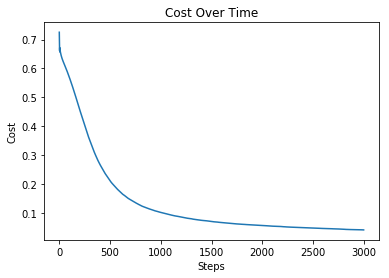

In [29]:
time = [i for i in range(3000)]
plt.plot(time,costs)
plt.title("Cost Over Time")
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.show()

### Adam optimization
I will be using Adam optimization to see if there will be better performance. Note - I am not using corrected values for Vdw,Sdw,Vdb,Sdb.

$$ Vdw = B_{1}Vdw + (1-B_1)dW$$
$$ Vdb = B_{1}Vdb + (1-B_1)db$$
$$ Sdw = B_{2}Sdw + (1-B_2)dW^2$$
$$ Sdb = B_{2}Sdb + (1-B_2)db^2$$

$$ w = w - \alpha\frac{Vdw}{\sqrt{Sdw} + \epsilon} $$
$$ b = b - \alpha\frac{Vdb}{\sqrt{Sdb} + \epsilon} $$

In [30]:
# Updates params using adam optimization
def update_params_adam(p, g, lr,ap, B1, B2, epsilon, i):
    """
    params (p): holds old parameters
    grads (g): holds old grads
    adam params (ap): includes Vdw,Vdb,Sdw,Sdb
    B1: controls momentum portion
    B2: controls RMSProp portion
    i: the number of iterations
    ap: holds updated parameters for parameter updating
    """
    ap = adam_get_new_params(g,ap, B1, B2, i)
    W1 = p['W1'] - lr*(ap['Vdw1'] / (np.sqrt(ap['Sdw1']) + epsilon))
    b1 = p['b1'] - lr*(ap['Vdb1'] / (np.sqrt(ap['Sdb1']) + epsilon))
    W2 = p['W2'] - lr*(ap['Vdw2'] / (np.sqrt(ap['Sdw2']) + epsilon))
    b2 = p['b2'] - lr*(ap['Vdb2'] / (np.sqrt(ap['Sdb2']) + epsilon))
    W3 = p['W3'] - lr*(ap['Vdw3'] / (np.sqrt(ap['Sdw3']) + epsilon))
    b3 = p['b3'] - lr*(ap['Vdb3'] / (np.sqrt(ap['Sdb3']) + epsilon))
    
    params = {"W1":W1,"b1":b1,"W2":W2,"b2":b2,"W3":W3,"b3":b3}
    return params,ap

In [31]:
def adam_get_new_params(g,ap, B1, B2, i):
    # Momentum portion
    Vdw1 = (B1 * ap['Vdw1']) + (1-B1) * g['dW1']
    Vdw2 = (B1 * ap['Vdw2']) + (1-B1) * g['dW2']
    Vdw3 = (B1 * ap['Vdw3']) + (1-B1) * g['dW3']
    Vdb1 = (B1 * ap['Vdb1']) + (1-B1) * g['db1']
    Vdb2 = (B1 * ap['Vdb2']) + (1-B1) * g['db2']
    Vdb3 = (B1 * ap['Vdb3']) + (1-B1) * g['db3']
    # RMSProp portion
    Sdw1 = (B2 * ap['Sdw1']) + (1-B2) * (g['dW1']**2)
    Sdw2 = (B2 * ap['Sdw2']) + (1-B2) * (g['dW2']**2)
    Sdw3 = (B2 * ap['Sdw3']) + (1-B2) * (g['dW3']**2)
    Sdb1 = (B2 * ap['Sdb1']) + (1-B2) * (g['db1']**2)
    Sdb2 = (B2 * ap['Sdb2']) + (1-B2) * (g['db2']**2)
    Sdb3 = (B2 * ap['Sdb3']) + (1-B2) * (g['db3']**2)
    
    adam_params = {"Vdw1":Vdw1,"Vdb1":Vdb1,"Sdw1":Sdw1,"Sdb1":Sdb1,
                   "Vdw2":Vdw2,"Vdb2":Vdb2,"Sdw2":Sdw2,"Sdb2":Sdb2,
                   "Vdw3":Vdw3,"Vdb3":Vdb3,"Sdw3":Sdw3,"Sdb3":Sdb3}
    return adam_params

In [32]:
# Testing my implementation using adam optimization
costs2,params2 = nn_model(simple_train_x,simple_train_y,[10,10],1000,0.01, True, True)

Cost at epoch 0: 0.8443682442048944
Cost at epoch 100: 0.026193268833820584
Cost at epoch 200: 0.018411259414310287
Cost at epoch 300: 0.014008222424049636
Cost at epoch 400: 0.011195582916823243
Cost at epoch 500: 0.009112273452631194
Cost at epoch 600: 0.007654349313652913
Cost at epoch 700: 0.007144418238638632
Cost at epoch 800: 0.006191576712585713
Cost at epoch 900: 0.005960177346494054


In [33]:
# Normal model for comparison
costs3,params3 = nn_model(simple_train_x,simple_train_y,[10,10],1000,0.03, True)

Cost at epoch 0: 0.6904021343188632
Cost at epoch 100: 0.5021123230236083
Cost at epoch 200: 0.3833752420462661
Cost at epoch 300: 0.3031124125763343
Cost at epoch 400: 0.24627716733470484
Cost at epoch 500: 0.2052666667691193
Cost at epoch 600: 0.17559872378608615
Cost at epoch 700: 0.15492217350687013
Cost at epoch 800: 0.13828609928079574
Cost at epoch 900: 0.1260559816023987


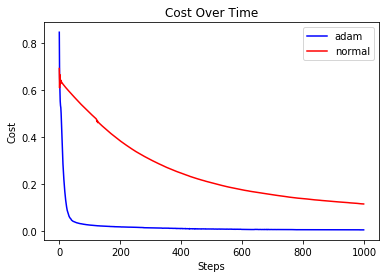

In [34]:
# The model with adam optimization does significantly better
time2 = [i for i in range(1000)]
plt.plot(time2,costs2,color="blue",label="adam")
plt.plot(time2,costs3,color="red",label="normal")
plt.legend()
plt.title("Cost Over Time")
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.show()